In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from p9_sp_clusters_data import *
from p6_rotations import topology_to_list
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

TypeError: bad operand type for unary -: 'list'

In [ ]:
#importing data frames
all_csv = pd.read_csv('all.csv').drop(['Unnamed: 0','all_corners_comb','all_edges_comb','no_edges_comb','no_corners_comb','all_comb'],axis=1)
df = pd.DataFrame(data=list_of_sp_clusters, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])
benchmark = pd.read_csv('benchmark_ds.csv').drop(['index','Unnamed: 7'],axis=1)

#creating full notation column in benchmark
benchmark['full_notation'] = benchmark['energy']
for cluster in range(len(benchmark)):
    benchmark['full_notation'].iloc[cluster] = str(benchmark['no_cluster'].iloc[cluster]) + '_'+benchmark['joining_type'].iloc[cluster]+'_'+benchmark['rotation'].iloc[cluster]

#creating new columns in df:
for column in ['no_nickel','number','joining_type','first_atom','second_atom','topology','c_atom','mass_center','shortest_paths','conformation','bonds']:
    df[column] = df['magnetism'] 

#gathering data from full notation columns
for cluster in range(len(df)):
    df['number'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[0] 
    df['joining_type'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[1]
    df['first_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[2])
    df['second_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[3])
    df['energy'].iloc[cluster] = float(df['energy'].iloc[cluster][1:])

#splitting shortest paths, conformation and bonds
for column in ['ni_ncentre','ni_centre','cu_ncentre','cu_centre','0ni','8ni','17ni','25ni','33ni','42ni','50ni', 'nini','cucu','nicu','type_of_first_atom','type_of_second_atom', 'hydrogen']:
    df[column] = df['magnetism']    

#gathering data from all.csv file and splitting shortest paths, conformation and bonds
for cluster in range(len(df)):
    for column in ['no_nickel','c_atom','mass_center','shortest_paths','conformation','bonds']:
        df[column].iloc[cluster] = all_csv[column].loc[int(df['number'].iloc[cluster])]
    for column in ['topology']:
        df[column].iloc[cluster] = topology_to_list(all_csv[column].loc[int(df['number'].iloc[cluster])])
    df['ni_ncentre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[0])[1:])
    df['ni_centre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[1])
    df['cu_ncentre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[2])
    df['cu_centre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[3])[:-1])
    df['0ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[0])[1:])
    df['50ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[6])[:-1])
    df['8ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[1]))
    df['17ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[2]))
    df['25ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[3]))
    df['33ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[4]))
    df['42ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[5]))
    df['nini'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[0])[1:])
    df['cucu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[2])[:-1])
    df['nicu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[1]))
    df['type_of_first_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['first_atom'].iloc[cluster]]
    df['type_of_second_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['second_atom'].iloc[cluster]]
    if df['joining_type'].iloc[cluster] in ['MOCOM','MOCM_H_n_bond']:
        df['hydrogen'].iloc[cluster] = 1
    else:
        df['hydrogen'].iloc[cluster] = 0

df = df[(df['joining_type']=='MOCMHnbond') | (df['joining_type']=='MOCOM') | (df['joining_type']=='MOCM')]
df = df[df['no_nickel'] <12]
df = df[df['no_nickel'] >2]
print('len:', len(df))
print(df['joining_type'].unique())
print(df['no_nickel'].unique())



C:\Users\stott\AppData\Local\Temp\ipykernel_3636\1890766315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark['full_notation'].iloc[cluster] = str(benchmark['no_cluster'].iloc[cluster]) + '_'+benchmark['joining_type'].iloc[cluster]+'_'+benchmark['rotation'].iloc[cluster]


len: 292
['MOCOM' 'MOCMHnbond' 'MOCM']
[6 5 4 7 3]


IndexError: single positional indexer is out-of-bounds

In [76]:
def ada(est,learning_rate):
    X = df.drop(['energy','first_atom','second_atom','SCF_steps','magnetism','time_of_calculation','number','bonds','conformation','shortest_paths','full_notation','joining_type','topology'],axis=1)
    y = np.asarray(df['energy']).astype('float32')
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    X = pd.DataFrame(data=X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)   
    model = AdaBoostRegressor(n_estimators=est, learning_rate=learning_rate)                     
        
    model.fit(X_train, y_train)
    model_pred = model.predict(X_test)

    error=(model_pred-y_test)
    srednia_error = 0    

    for i in range(len(error)):
        srednia_error+= np.sqrt(error[i]**2)           
    srednia_error /= len(error)   
    acc = 1-(srednia_error/sum(y_test)*len(y_test)) 
    #acc = 1-(srednia_error/(max(y_test)-min(y_test)))     
    return(acc, y_test, model_pred)
    
def printing(model, y_test):  
    
    frame = []

    for char in range(len(model)):
        preframe = []
        preframe.append(model[char][0])
        preframe.append(y_test[char])
        frame.append(preframe)    
    #frame = pd.DataFrame(data=(frame))
    #scaler = MinMaxScaler()
    #scaler.fit(frame)
    #frame = scaler.transform(frame)
    frame = pd.DataFrame(data=frame, columns =['y_test','model_pred'])   
    frame = frame.sort_values(by=['y_test']).reset_index(drop=True)
    sns.scatterplot(data=frame)
    #plt.ylim(0, 75)
    #return frame


def create_model(X, activation, n):
    
    model = Sequential()
    model.add(Dense(units=len(X.columns), activation=activation, input_dim=len(X.columns)))
    for layer in range(1,n):
            model.add(Dense(units=4*2**layer, activation='relu'))
    model.add(Dense(units=1, activation=activation))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

acc: 0.8187494677942 act: relu number_of_layers: 2 batch:  8
acc: 0.8220046483778356 act: relu number_of_layers: 2 batch:  16
acc: 0.8216973620456077 act: relu number_of_layers: 2 batch:  32
acc: 0.8129601079479291 act: relu number_of_layers: 2 batch:  64
acc: 0.8202740719242865 act: relu number_of_layers: 3 batch:  8
acc: 0.8218484942241578 act: relu number_of_layers: 3 batch:  16
acc: 0.8211138163320538 act: relu number_of_layers: 3 batch:  32
acc: 0.8209153740292937 act: relu number_of_layers: 3 batch:  64
acc: 0.8221953414817169 act: relu number_of_layers: 4 batch:  8
acc: 0.5162512108049699 act: relu number_of_layers: 4 batch:  16
acc: 0.8204605977008286 act: relu number_of_layers: 4 batch:  32
acc: 0.8210203603757583 act: relu number_of_layers: 4 batch:  64
acc: 0.8179794238852504 act: relu number_of_layers: 5 batch:  8
acc: 0.8180992338107586 act: relu number_of_layers: 5 batch:  16
acc: 0.8200860722112834 act: relu number_of_layers: 5 batch:  32
acc: 0.8172485172552242 act: rel

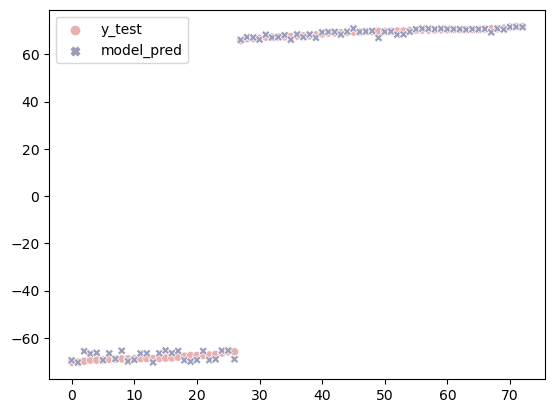

In [77]:
X = (df.drop(['energy','first_atom','second_atom','SCF_steps','magnetism','time_of_calculation','number','bonds','conformation','shortest_paths','full_notation','joining_type','topology'],axis=1))
X = pd.get_dummies(data = X, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
y = np.asarray(df['energy']).astype('float32')
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X = pd.DataFrame(data=X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
best_acc = [0]
for activation in ['relu','linear']:
    for n in [2,3,4,5]:
        for batch in [8,16,32,64]:
            early_stop = EarlyStopping(monitor='loss', mode='min', patience=15, restore_best_weights = True)
            model = create_model(X,activation,n)
            model.fit(X_train, y_train, epochs=300, batch_size=batch, callbacks=[early_stop], verbose = 0)
            model_pred = model.predict(X_test) 
            srednia_error = 0    

            for i in range(len(model_pred)):
                srednia_error+= np.sqrt((model_pred[i][0]-y_test[i])**2)            
            srednia_error /= len(model_pred)   

            acc = 1-(srednia_error/(max(y_test)-min(y_test)))   
            print('acc:',acc, 'act:', activation, 'number_of_layers:', n, 'batch: ', batch)
            if acc > best_acc[0]:
                best_acc = [acc, activation, n, batch]
                model.save('tfmodel.h5') 
print(best_acc)


model = load_model('tfmodel.h5')
model_pred = model.predict(X_test)
printing(model_pred,y_test)
srednia_error = 0  

for i in range(len(model_pred)):
    srednia_error+= np.sqrt((model_pred[i][0]-y_test[i])**2)            
srednia_error /= len(model_pred)   

acc = 1-(srednia_error/(max(y_test)-min(y_test))) 
print('final accuracy: ', acc)

#later_model.predict(new_gem)




In [358]:

best_model = [0,0,0]
for estimator in [50,100,150,200,250,300]:
    for learning_rate in [x for x in range(1,11,1)]:
        current_model = ada(estimator,learning_rate)
        #print(estimator, learning_rate, current_model[0])
        if best_model[2] < current_model[0]:
            best_model = [estimator,learning_rate,current_model[0]]
            print(best_model)
var = printing(ada(best_model[0],best_model[1]))

ValueError: could not convert string to float: 'Cu'

## Drawing Aproximate Accuracy Plot

In [ ]:
sp_on_benchmark_cases = pd.DataFrame(data=sp_on_benchmark_cases, columns = ['full_notation','aproximate_energy','SCF_steps','magnetism','time'])
for char in range(len(sp_on_benchmark_cases)):
    sp_on_benchmark_cases['aproximate_energy'].iloc[char] = float(sp_on_benchmark_cases['aproximate_energy'].iloc[char])
benchmark_merge = benchmark.merge(sp_on_benchmark_cases, left_on='full_notation', right_on='full_notation')
benchmark_merge = benchmark_merge[['energy','aproximate_energy']].sort_values(by=['energy']).reset_index(drop=True)

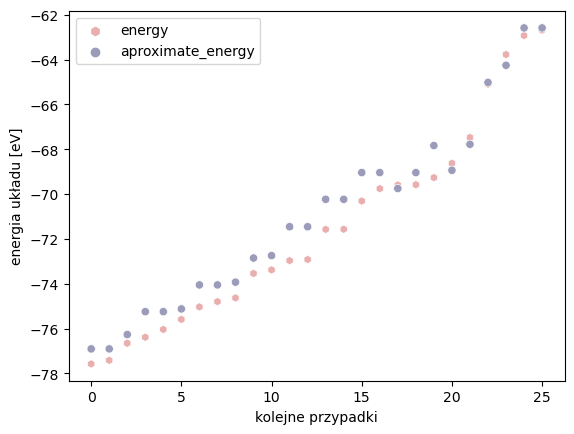

In [52]:

colors = ['#e9aeae','#9b9bba']

sns.set_palette(sns.color_palette(colors))
markers = {"energy": "h", "aproximate_energy": "o"}
ax = sns.scatterplot(data = benchmark_merge, markers=markers )
ax.set_xlabel("kolejne przypadki")
ax.set_ylabel("energia układu [eV]")
plt.savefig('aproximate_accuracy.png')

In [72]:
benchmark.merge(df, left_on='no_cluster', right_on='number')


ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat

In [85]:
df.head()

,full_notation,energy,SCF_steps,magnetism,time_of_calculation,no_nickel,number,joining_type,first_atom,second_atom,...,25ni,33ni,42ni,50ni,nini,cucu,nicu,type_of_first_atom,type_of_second_atom,hydrogen
1,58_MOCOM_7_11,70.411401,118,2.00,113.04m,6,58,MOCOM,7,11,...,5,3,1,0,24,36,24,Cu,Cu,1
6,59_MOCOM_1_6,70.699663,67,2.00,47.35m,6,59,MOCOM,1,6,...,3,5,0,0,22,40,22,Ni,Cu,1
7,59_MOCOM_7_11,70.690372,64,2.00,42.76m,6,59,MOCOM,7,11,...,3,5,0,0,22,40,22,Ni,Cu,1
8,59_MOCOM_10_11,70.445968,107,2.00,103.00m,6,59,MOCOM,10,11,...,3,5,0,0,22,40,22,Cu,Cu,1
11,60_MOCOM_7_11,70.596544,76,2.00,37.12m,6,60,MOCOM,7,11,...,6,4,0,0,20,44,20,Cu,Ni,1
